2025-06-15 21:04:14,398 - INFO - Calculating ATR-Adaptive MA...
2025-06-15 21:04:15,890 - INFO - Chart saved to BTCUSD_AMA_chart.png


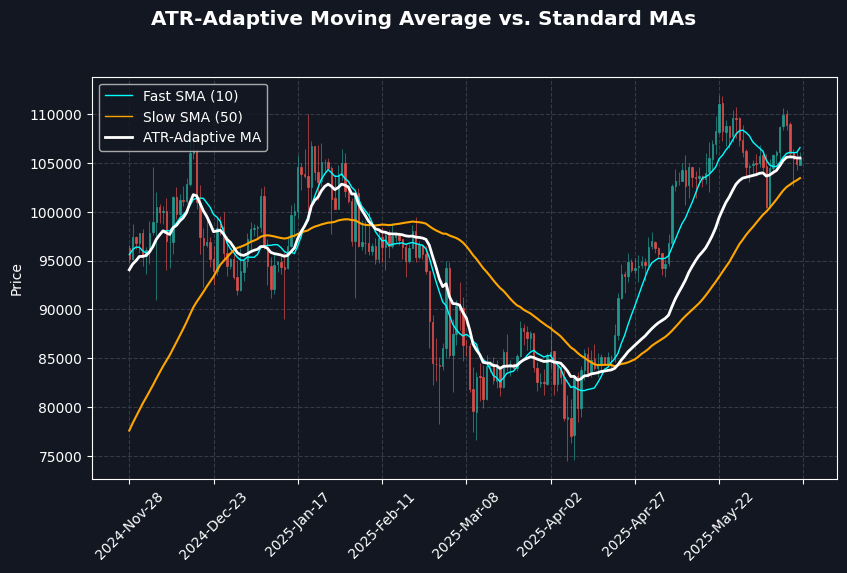

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.lines as mlines 
import logging

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# calculate_true_range and calculate_atr_adaptive_ma functions
def calculate_true_range(df: pd.DataFrame) -> pd.Series:
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr

def calculate_atr_adaptive_ma(df: pd.DataFrame, fast_period: int, slow_period: int, atr_period: int) -> pd.Series:
    logging.info("Calculating ATR-Adaptive MA...")
    df['TR'] = calculate_true_range(df)
    df['ATR'] = df['TR'].ewm(alpha=1/atr_period, adjust=False).mean()
    min_atr = df['ATR'].rolling(window=slow_period).min()
    max_atr = df['ATR'].rolling(window=slow_period).max()
    atr_range = max_atr - min_atr
    atr_range[atr_range == 0] = 1 
    volatility_intensity = (df['ATR'] - min_atr) / atr_range
    volatility_intensity = volatility_intensity.fillna(0)
    alpha_fast = 2 / (fast_period + 1)
    alpha_slow = 2 / (slow_period + 1)
    dynamic_alpha = volatility_intensity * (alpha_fast - alpha_slow) + alpha_slow
    ama = pd.Series(index=df.index, dtype='float64')
    ama.iloc[0] = df['Close'].iloc[0]
    for i in range(1, len(df)):
        ama.iloc[i] = (df['Close'].iloc[i] * dynamic_alpha.iloc[i]) + (ama.iloc[i-1] * (1 - dynamic_alpha.iloc[i]))
    return ama

# --- Main execution block ---
if __name__ == "__main__":
    if not mt5.initialize(): logging.error("initialize() failed"); mt5.shutdown(); exit()
    
    SYMBOL = "BTCUSD"; TIME_FRAME = mt5.TIMEFRAME_D1; NUM_BARS = 500
    rates = mt5.copy_rates_from_pos(SYMBOL, TIME_FRAME, 0, NUM_BARS)
    mt5.shutdown()
    
    if rates is None or len(rates) == 0:
        logging.error("No data fetched.")
    else:
        df = pd.DataFrame(rates)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('time', inplace=True)
        df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)

        FAST_PERIOD = 10; SLOW_PERIOD = 50
        df['SMA_fast'] = df['Close'].rolling(window=FAST_PERIOD).mean()
        df['SMA_slow'] = df['Close'].rolling(window=SLOW_PERIOD).mean()
        df['AMA'] = calculate_atr_adaptive_ma(df, fast_period=FAST_PERIOD, slow_period=SLOW_PERIOD, atr_period=14)

        df_to_plot = df.tail(200)

        ap_fast = mpf.make_addplot(df_to_plot['SMA_fast'], color='cyan', width=1)
        ap_slow = mpf.make_addplot(df_to_plot['SMA_slow'], color='orange', width=1.5)
        ap_ama = mpf.make_addplot(df_to_plot['AMA'], color='white', width=2)
        addplots = [ap_fast, ap_slow, ap_ama]

        tv_marketcolors = mpf.make_marketcolors(up='#26a69a', down='#ef5350', edge='inherit', wick='inherit')
        tv_style = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=tv_marketcolors, facecolor='#131722', figcolor='#131722', gridcolor='#363a45')
        
        output_filename = f'{SYMBOL}_AMA_chart.png'
        fig, axlist = mpf.plot(
            df_to_plot, type='candle', style=tv_style,
            title='ATR-Adaptive Moving Average vs. Standard MAs',
            addplot=addplots, figratio=(18,10), returnfig=True
        )

        ax_price = axlist[0]
        # Create custom lines (handles) for the legend
        fast_line = mlines.Line2D([], [], color='cyan', label=f'Fast SMA ({FAST_PERIOD})')
        slow_line = mlines.Line2D([], [], color='orange', label=f'Slow SMA ({SLOW_PERIOD})')
        ama_line = mlines.Line2D([], [], color='white', linewidth=2, label='ATR-Adaptive MA')

        # Add the legend with the custom handles
        ax_price.legend(handles=[fast_line, slow_line, ama_line], loc='upper left')
        

        fig.savefig(output_filename, dpi=150)
        logging.info(f"Chart saved to {output_filename}")